In [13]:
import polars as pl
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pl.read_csv("datasource/Donnees_changement_climatique-SIM_décadaire/DECAD_SIM2_*.csv.gz", has_header=True, separator=";")

In [4]:
dfp = df.to_pandas();


In [5]:
''' Aperçu du jeu de données initial (brut) '''
dfp.head(5)

,LAMBX,LAMBY,DATE,DECADE,PRENEI_DECAD,PRELIQ_DECAD,PRETOTD_DECAD,T_DECAD,EVAP_DECAD,ETP_DECAD,PE_DECAD,SWI_DECAD,SSWI_DECAD,ECOULEMENT_DECAD,DRAINC_DECAD,RUNC_DECAD
0,600,24010,195808,1,0.0,35.4,35.4,16.3,15.1,25.4,20.3,0.347,-1.10,0.0,0.0,1.0
1,600,24010,195808,2,0.0,37.5,37.5,16.6,18.9,24.3,18.6,0.398,-0.54,0.0,0.0,1.4
2,600,24010,195808,3,0.0,28.2,28.2,15.7,24.9,24.4,3.3,0.470,0.23,0.0,0.3,1.0
3,600,24010,195809,1,0.0,13.4,13.4,17.3,21.0,25.0,-7.6,0.451,0.01,0.0,0.0,0.4
4,600,24010,195809,2,0.0,39.6,39.6,16.8,14.9,16.1,24.7,0.424,-0.26,0.0,0.1,1.9


In [6]:
''' Transformation des coordonnées projetées en mètre à partir des hectomètre '''
dfp["LAMBX"] = dfp["LAMBX"] * 100
dfp["LAMBY"] = dfp["LAMBY"] * 100 

In [7]:
""" Interval de dates du jeu de données """
print(dfp['DATE'].values.min(), dfp['DATE'].values.max())

195808 202509


In [8]:
''' Construction de trois dates par mois à partir de l'information du numero de deacade'''
dfp_decade1 = dfp.loc[dfp["DECADE"] == 1]
dfp_decade23 = dfp.loc[dfp["DECADE"] > 1]
DATE_TO_PARSE_1 = dfp_decade1['DATE'].astype(str) + '0' + ((dfp_decade1['DECADE']*10)-9).astype(str)
DATE_TO_PARSE_2 = dfp_decade23['DATE'].astype(str) + ((dfp_decade23['DECADE']*10)-9).astype(str)
Date_res = DATE_TO_PARSE_1.combine (DATE_TO_PARSE_2,max,fill_value='0') 
dfp['DATE_TO_PARSE'] = Date_res.astype("string")
dfp['DATE_TO_PARSE'].head(10)

0    19580801
1    19580811
2    19580821
3    19580901
4    19580911
5    19580921
6    19581001
7    19581011
8    19581021
9    19581101
Name: DATE_TO_PARSE, dtype: string

In [9]:
dfp['Date'] =  pandas.to_datetime(arg=dfp['DATE_TO_PARSE'] , format = "%Y%m%d")
dfp.drop(labels='DATE_TO_PARSE', axis=1, inplace=True)

In [10]:
''' Aperçu des données '''
pandas.set_option("display.max_columns", None)
dfp.head()

,LAMBX,LAMBY,DATE,DECADE,PRENEI_DECAD,PRELIQ_DECAD,PRETOTD_DECAD,T_DECAD,EVAP_DECAD,ETP_DECAD,PE_DECAD,SWI_DECAD,SSWI_DECAD,ECOULEMENT_DECAD,DRAINC_DECAD,RUNC_DECAD,Date
0,60000,2401000,195808,1,0.0,35.4,35.4,16.3,15.1,25.4,20.3,0.347,-1.10,0.0,0.0,1.0,1958-08-01
1,60000,2401000,195808,2,0.0,37.5,37.5,16.6,18.9,24.3,18.6,0.398,-0.54,0.0,0.0,1.4,1958-08-11
2,60000,2401000,195808,3,0.0,28.2,28.2,15.7,24.9,24.4,3.3,0.470,0.23,0.0,0.3,1.0,1958-08-21
3,60000,2401000,195809,1,0.0,13.4,13.4,17.3,21.0,25.0,-7.6,0.451,0.01,0.0,0.0,0.4,1958-09-01
4,60000,2401000,195809,2,0.0,39.6,39.6,16.8,14.9,16.1,24.7,0.424,-0.26,0.0,0.1,1.9,1958-09-11


In [11]:
''' Ajout de l'information sur le mois de l'année (type categorie et cyclique que l'on va encoder)'''
dfp['num_mois'] = dfp['Date'].dt.month
''' Variable mois_cos permet d'obtenir la proximité de valeurs des mois appartenant à la même saison '''
import numpy as np
dfp['mois_cos'] = np.cos( (dfp['Date'].dt.month-1) * 2 * np.pi / 11 ) 
dfp['saison'] = dfp['num_mois'].replace(to_replace=[[1,2,12],[3,4,5],[6,7,8],[9,10,11]], value=[0, 1, 2, 1])

<Axes: >

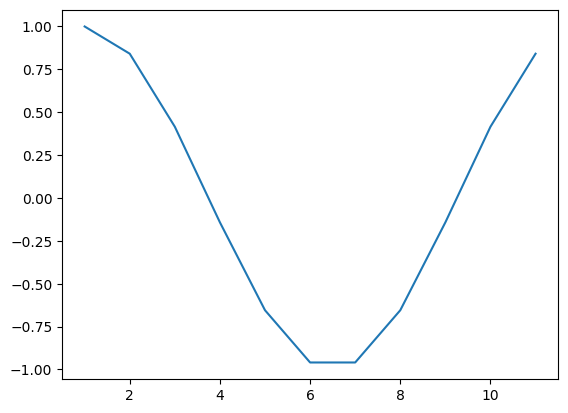

In [14]:
num_mois = range(1,12)
cos_mois = [np.cos( (i-1) * 2 * np.pi / 11 ) for i in num_mois]
sns.lineplot(x=num_mois, y=cos_mois )

In [16]:
''' Filtre des données sur certaines latitudes seulement - restriction aux mesures situées au sud de Clermont-Ferrand '''
#dfp = dfp.loc[ dfp["LAMBY"] < 2089000]
dfp_marseille_12me = dfp.loc[dfp["LAMBX"] == 852000].loc[ dfp["LAMBY"] == 1817000]

In [17]:
dfp_marseille_12me.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2417 entries, 381633 to 23412915
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   LAMBX             2417 non-null   int64         
 1   LAMBY             2417 non-null   int64         
 2   DATE              2417 non-null   int64         
 3   DECADE            2417 non-null   int64         
 4   PRENEI_DECAD      2417 non-null   float64       
 5   PRELIQ_DECAD      2417 non-null   float64       
 6   PRETOTD_DECAD     2417 non-null   float64       
 7   T_DECAD           2417 non-null   float64       
 8   EVAP_DECAD        2417 non-null   float64       
 9   ETP_DECAD         2417 non-null   float64       
 10  PE_DECAD          2417 non-null   float64       
 11  SWI_DECAD         2417 non-null   float64       
 12  SSWI_DECAD        2416 non-null   float64       
 13  ECOULEMENT_DECAD  2417 non-null   float64       
 14  DRAINC_DECAD      24

In [18]:
''' Codage d'une information sur la saison '''
#dfp['saison'] = dfp['saison'].replace(to_replace=[[1,2,12],[3,4,5],[6,7,8],[9,10,11]], value=[0, 1, 2, 1])
dfp_marseille_12me['saison'] = dfp_marseille_12me['num_mois'].replace(to_replace=[1,2,12], value=1).replace(to_replace=[3,4,5], value=2).replace(to_replace=[6,7,8], value=3).replace(to_replace=[9,10,11], value=4)

In [19]:
dfp_marseille_12me.drop(columns=['DATE','DECADE','Date', 'LAMBX', 'LAMBY'], inplace=True )

In [20]:
dfp_marseille_12me.head()

,PRENEI_DECAD,PRELIQ_DECAD,PRETOTD_DECAD,T_DECAD,EVAP_DECAD,ETP_DECAD,PE_DECAD,SWI_DECAD,SSWI_DECAD,ECOULEMENT_DECAD,DRAINC_DECAD,RUNC_DECAD,num_mois,mois_cos,saison
381633,0.0,0.2,0.2,23.2,1.8,58.0,-1.6,0.057,-0.64,0.0,0.0,0.0,8,-0.654861,3
381634,0.0,0.2,0.2,22.7,1.5,51.8,-1.3,0.046,-0.60,0.0,0.0,0.0,8,-0.654861,3
381635,0.0,5.6,5.6,21.6,5.2,42.8,0.4,0.053,-0.32,0.0,0.0,0.0,8,-0.654861,3
381636,0.0,1.6,1.6,21.7,2.3,32.3,-0.7,0.044,-0.72,0.0,0.0,0.0,9,-0.142315,4
381637,0.0,30.9,30.9,20.9,11.6,28.4,19.3,0.110,-0.30,0.0,0.3,0.9,9,-0.142315,4


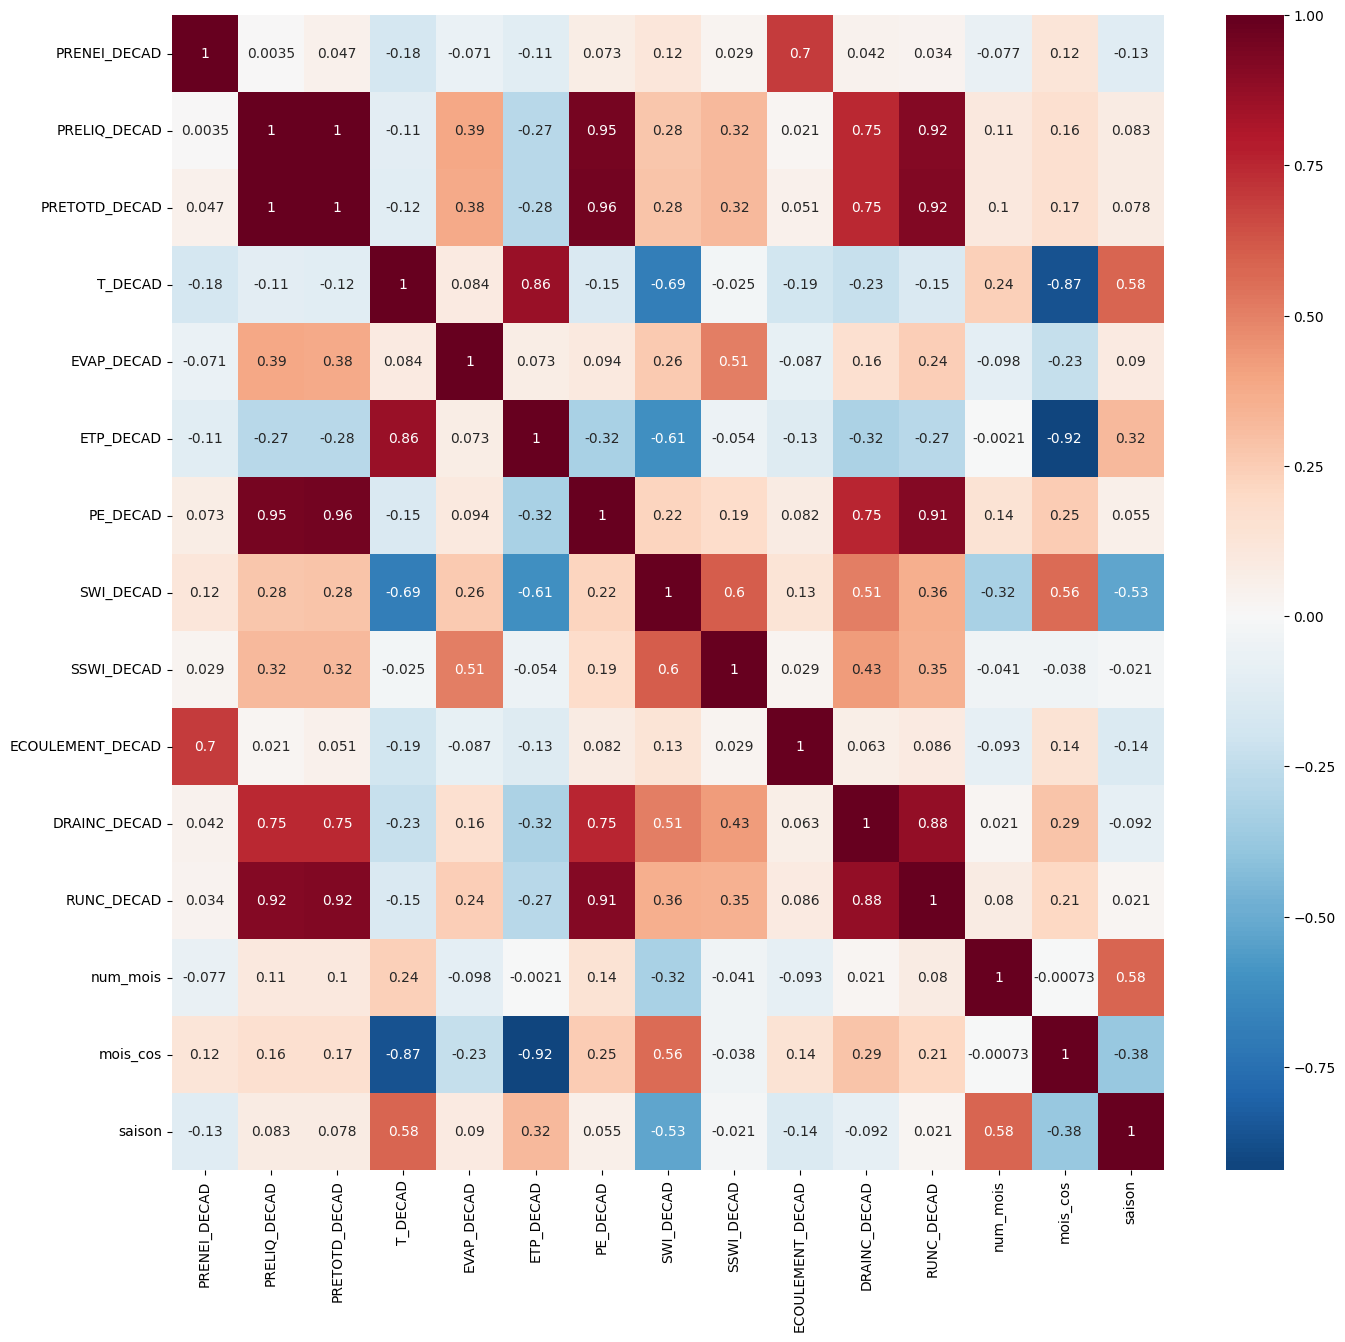

In [21]:
''' Analyses des corrélations '''
plt.figure(figsize=(16, 15))
sns.heatmap(dfp_marseille_12me.corr(), annot=True, cmap='RdBu_r', center=0);

Regressions possibles :
- T_decad = f((mois_cos, etp_decad_ swi_decad) 
- swi_decad = f(T, etp_decad, mois_cos)
- etp_decad  = f(T, swi_decad, mois_cos)

avec :
- ETP_DECAD : Evapotranspiration potentielle
- SWI_DECAD : Indice d humidité des sols

On choisi de prédire : <br/> etp_decad = f(T, swi_decad, mois_cos) 
<br/> -> l'évapotranspiration à partir de la temperature, du mois de l'année et de l'indice d'humidité des sols

<Axes: xlabel='mois_cos', ylabel='ETP_DECAD'>

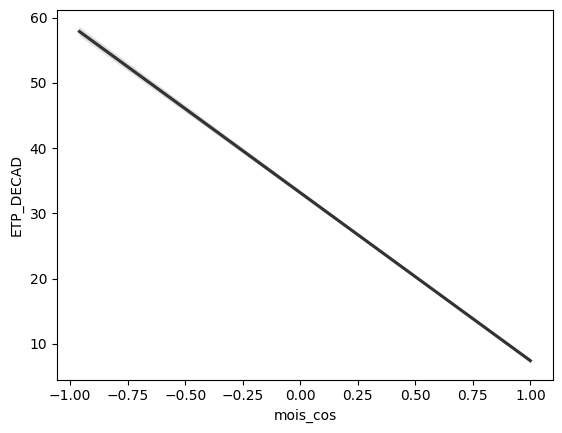

In [22]:
''' Essai de regression basique d'ordre 1 (lineaire) entre les deux variables les plus correlés '''
ax = sns.regplot(
    data=dfp_marseille_12me, x="mois_cos", y="ETP_DECAD",
    scatter=False, 
    truncate=True, # If True, the regression line is bounded by the data limits. If False, it extends to the x axis limits.
    order=1,
    color=".2",
)
ax # type : matplotlib.axes._axes.Axes

In [59]:
from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import root_mean_squared_error

<Axes: xlabel='SWI_DECAD', ylabel='Count'>

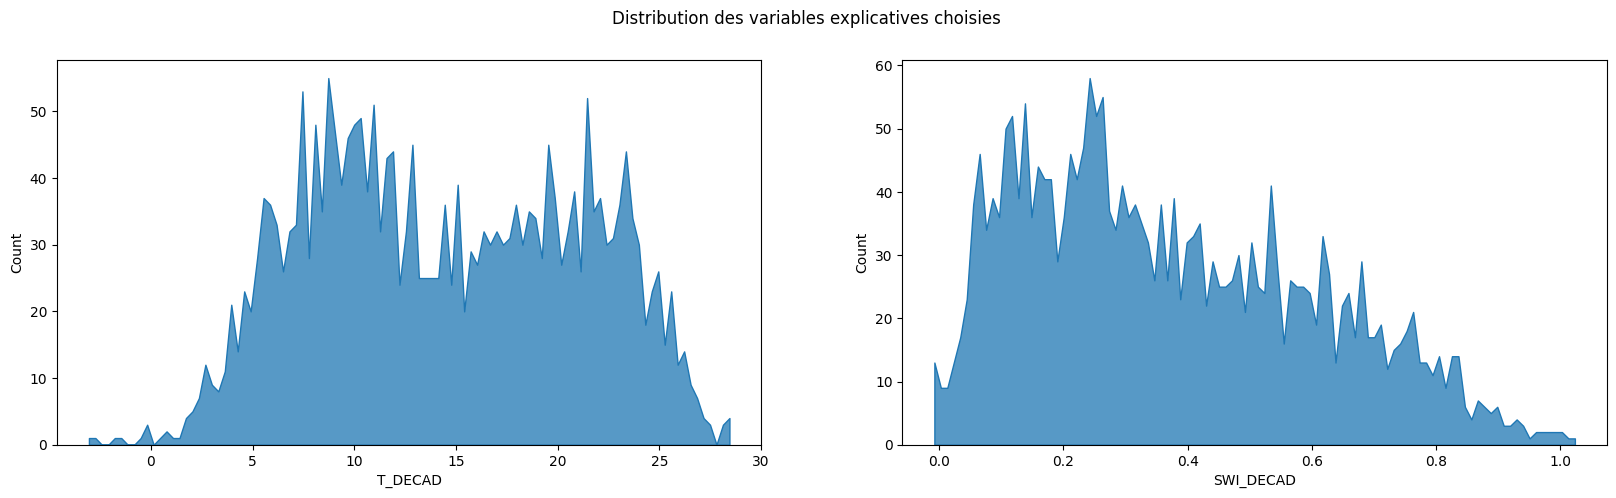

In [24]:
''' Etude de la distribution des variables Temperature 'T_DECAD' et 'Indice d humidité des sols'''
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
fig.suptitle('Distribution des variables explicatives choisies')

sns.histplot( data = dfp_marseille_12me['T_DECAD'],element='poly', bins=100, ax=axs[0])
sns.histplot( data = dfp_marseille_12me['SWI_DECAD'],element='poly', bins=100, ax=axs[1])

In [25]:
''' Préparation des données en vue de l'apprentissage des algos d'aprentissages supervisés de type régression '''
data = dfp_marseille_12me.loc[: ,['T_DECAD', 'SWI_DECAD', 'mois_cos']]
target = dfp_marseille_12me['ETP_DECAD']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

<Axes: ylabel='Count'>

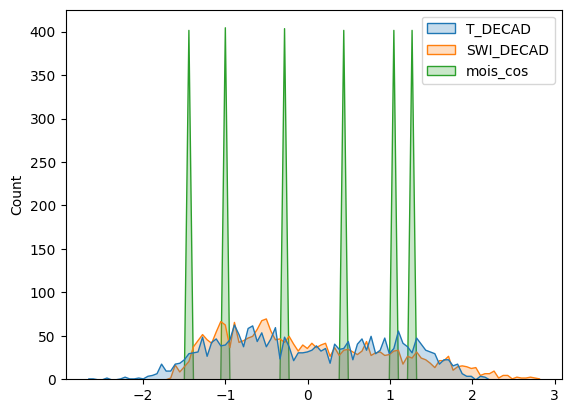

In [26]:
''' Visualisation de données normalisées '''
scaler = preprocessing.StandardScaler()
T_DECAD_NORM = pandas.DataFrame(scaler.fit_transform(data), index= data.index, columns=data.columns)
ax = sns.histplot( data =T_DECAD_NORM ,element='poly', bins=100)
ax

In [27]:
X_train.head()

,T_DECAD,SWI_DECAD,mois_cos
10320873,11.3,0.743,-0.142315
10320887,21.5,0.161,-0.654861
21003976,4.0,0.775,0.841254
17443114,16.9,0.210,-0.142315
3198461,22.8,0.210,-0.959493


In [28]:
# On ne veut pas normaliser la colonne 'mois_cos' donc on l'exclu
valeurs_train_normalisees = scaler.fit_transform(X_train.drop(columns=['mois_cos']))
valeurs_train_normalisees

array([[-0.4811861 ,  1.6078767 ],
       [ 1.07823365, -0.89947114],
       [-1.59724141,  1.74573775],
       ...,
       [ 0.66544607, -0.16708431],
       [ 1.6286171 , -1.00717508],
       [ 1.42986752, -1.38198481]], shape=(1933, 2))

In [29]:
X_train.columns

Index(['T_DECAD', 'SWI_DECAD', 'mois_cos'], dtype='object')

In [30]:
''' Normalisation des donnnées des variables explicatives afin que l'algo d'apprentissage soit plus efficace'''
X_train_temp = pandas.DataFrame(valeurs_train_normalisees, index=X_train.index, columns= ['T_DECAD', 'SWI_DECAD'])
# TODO : X_test[X_test.columns] = pandas.DataFrame(scaler.transform(X_test), index=X_test.index)
X_train_temp = X_train_temp.rename(columns={"T_DECAD": "T_DECAD_NORM", "SWI_DECAD": "SWI_DECAD_NORM"})
''' Pour info : pour retrouver les valeurs originales : X_original = StandardScaler.inverse_transform(X_normalise)  '''

' Pour info : pour retrouver les valeurs originales : X_original = StandardScaler.inverse_transform(X_normalise)  '

In [31]:
X_train_temp.head()

,T_DECAD_NORM,SWI_DECAD_NORM
10320873,-0.481186,1.607877
10320887,1.078234,-0.899471
21003976,-1.597241,1.745738
17443114,0.374966,-0.688371
3198461,1.276983,-0.688371


In [32]:
# X_train.loc[:, 'T_DECAD_NORM'] = X_train_temp.loc[:, 'T_DECAD']
# Pour ajouter plusieurs colonnes à X_train à partir de ceux de X_train_temp
X_train = X_train.join(X_train_temp, how="inner")

In [33]:
X_train.head()

,T_DECAD,SWI_DECAD,mois_cos,T_DECAD_NORM,SWI_DECAD_NORM
10320873,11.3,0.743,-0.142315,-0.481186,1.607877
10320887,21.5,0.161,-0.654861,1.078234,-0.899471
21003976,4.0,0.775,0.841254,-1.597241,1.745738
17443114,16.9,0.210,-0.142315,0.374966,-0.688371
3198461,22.8,0.210,-0.959493,1.276983,-0.688371


In [34]:
''' Modele à une seule variable explicative '''
model_1 = LinearRegression()
model_1.fit(X_train.loc[:,['T_DECAD_NORM']], y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
''' Normallisation des données du jeu de test : X_test '''
valeurs_test_normalisees = scaler.fit_transform(X_test.drop(columns=['mois_cos']))
X_test_temp = pandas.DataFrame(valeurs_test_normalisees, index=X_test.index, columns= ['T_DECAD', 'SWI_DECAD'])
X_test_temp = X_test_temp.rename(columns={"T_DECAD": "T_DECAD_NORM", "SWI_DECAD": "SWI_DECAD_NORM"})
X_test = X_test.join(X_test_temp, how="inner")
X_test.head()

,T_DECAD,SWI_DECAD,mois_cos,T_DECAD_NORM,SWI_DECAD_NORM
21004062,22.6,0.149,-0.959493,1.241063,-0.966257
21004301,10.6,0.534,0.841254,-0.581095,0.697751
17443150,11.9,0.264,-0.142315,-0.383695,-0.469216
17442856,8.2,0.443,0.841254,-0.945527,0.304440
3198530,18.5,0.401,-0.654861,0.618492,0.122912


In [60]:
''' Evaluation de la qualité du modèle de regression linéaire à 1 variable '''
print('score test :', model_1.score(X_test[['T_DECAD_NORM']], y_test))
pred = model_1.predict(X_train[['T_DECAD_NORM']])
pred_test = model_1.predict(X_test[['T_DECAD_NORM']])
print('rmse test : ', np.sqrt(root_mean_squared_error(y_test, pred_test)))

score test : 0.7668533974634875
rmse test :  3.092047168879126


In [37]:
''' Modele de regression linéaire à 3 variables explicatives '''
model_3 = LinearRegression()
model_3.fit(X_train.loc[:,['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']], y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [61]:
''' Evaluation de la qualité du modèle de regression linéaire à 3 variables '''
print('score test :', model_3.score(X_test.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']], y_test))
pred_3 = model_3.predict(X_train.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']])
pred_test_3 = model_3.predict(X_test.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']])
print('rmse test : ', np.sqrt(root_mean_squared_error(y_test, pred_test_3)))

score test : 0.8765345573194272
rmse test :  2.6376987412584554


In [52]:
 diff_erreur = 100 * ((9.560755694573416 - 6.8921150529754) / 9.560755694573416)
diff_erreur

27.912444652389862

L'erreur commise par le modèle de regression linéaire à 3 variables explicatives, est de 27,9 % inférieure à celui utilisant une seule variable explicative.

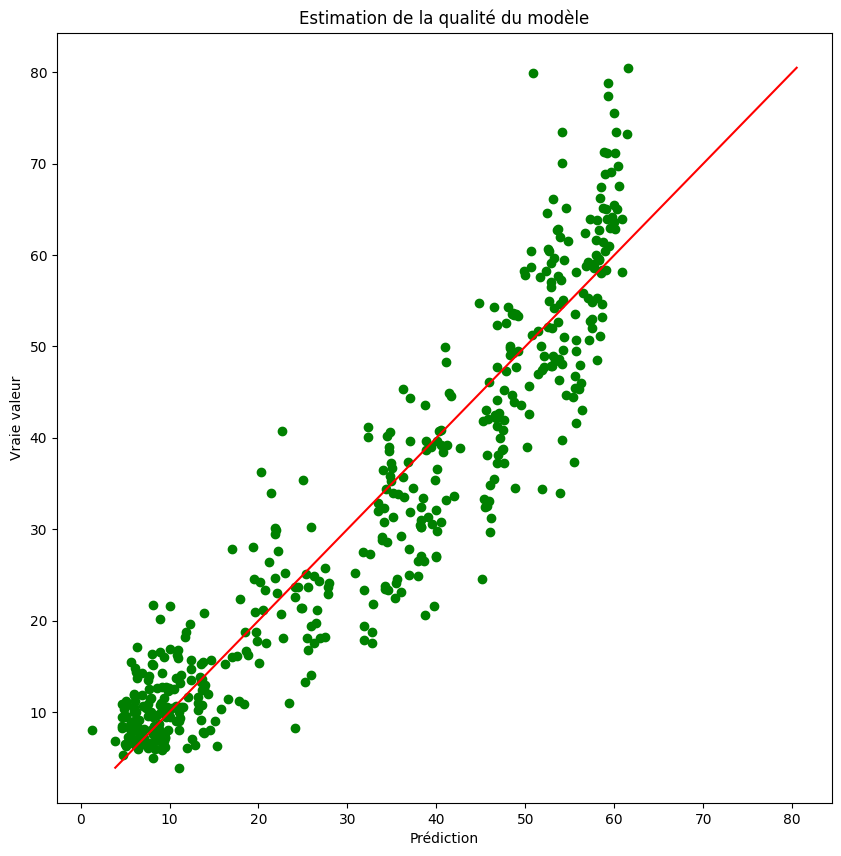

In [41]:
fig = plt.figure(figsize=(10,10))

plt.scatter(pred_test_3, y_test, c="green")
plt.plot((y_test.min(),y_test.max()),(y_test.min(),y_test.max()), color = "red")

plt.xlabel("Prédiction")
plt.ylabel("Vraie valeur")
plt.title("Estimation de la qualité du modèle")
plt.show();

---------------------------------------------------
**Modelisations par Regression polynomiale d'ordre 2**

Etude d'un cas à une variable explicative : Modélisation de la température en fonction du mois de l'année

In [42]:
df_temperatures_mois_cos = dfp_marseille_12me.groupby(by='mois_cos').agg({'T_DECAD': "mean"})
df_temperatures_mois = dfp_marseille_12me.groupby(by='num_mois').agg({'T_DECAD': "mean"})

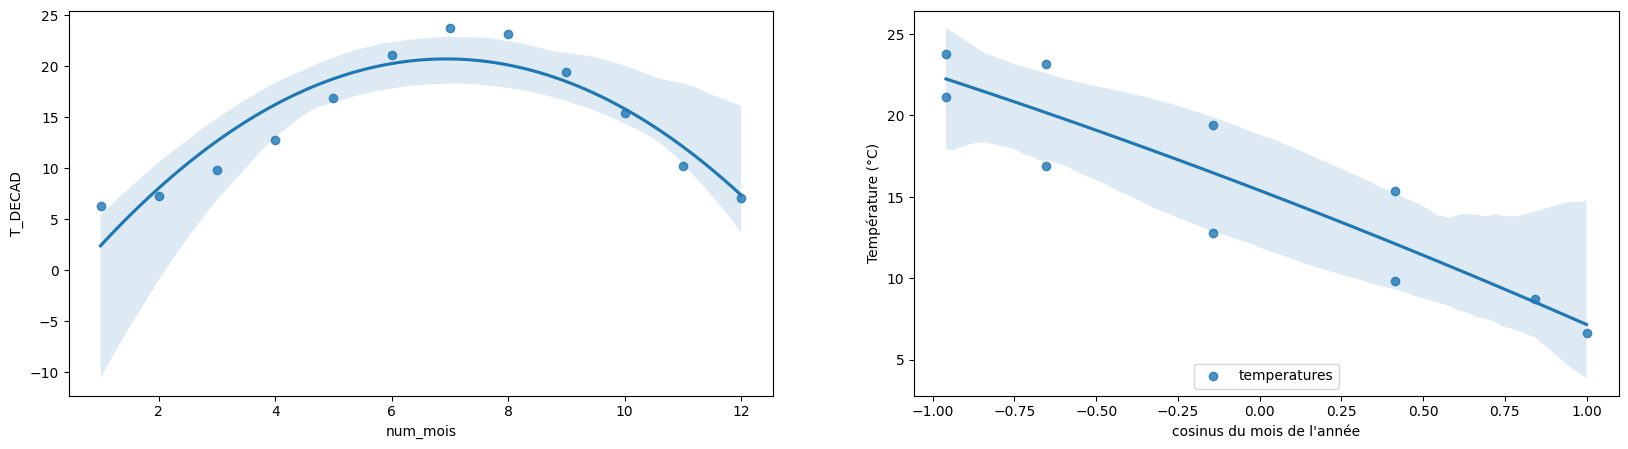

In [43]:
#plt.figure(figsize=(6,5))
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
sns.regplot(data=df_temperatures_mois, x=df_temperatures_mois.index, y='T_DECAD',order=2, label='temperatures', ax=axs[0]);
sns.regplot(data=df_temperatures_mois_cos, x=df_temperatures_mois_cos.index, y='T_DECAD',order=2, label='temperatures', ax=axs[1]);

plt.ylabel('Température (°C)')
plt.xlabel("cosinus du mois de l'année")
plt.legend(loc='lower center')


Toujours pour prédire : etp_decad <br/>
(l'évapotranspiration à partir de la temperature, du mois de l'année et de l'indice d'humidité des sols) <br/>
 On essai un modèle de regresssion polynomiale d'ordre 2


 On essai un modèle de regresssion polynomiale d'ordre 2 avec la seule variable T_DECAD

In [44]:
''' Rappel du jeu de données des variables explicatives'''
X_train.head()

,T_DECAD,SWI_DECAD,mois_cos,T_DECAD_NORM,SWI_DECAD_NORM
10320873,11.3,0.743,-0.142315,-0.481186,1.607877
10320887,21.5,0.161,-0.654861,1.078234,-0.899471
21003976,4.0,0.775,0.841254,-1.597241,1.745738
17443114,16.9,0.210,-0.142315,0.374966,-0.688371
3198461,22.8,0.210,-0.959493,1.276983,-0.688371


In [45]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_T_poly_ordre2 = poly.fit_transform(X_train.loc[:,['T_DECAD_NORM']])
X_T_poly_ordre2

array([[ 1.        , -0.4811861 ,  0.23154006],
       [ 1.        ,  1.07823365,  1.16258781],
       [ 1.        , -1.59724141,  2.55118012],
       ...,
       [ 1.        ,  0.66544607,  0.44281847],
       [ 1.        ,  1.6286171 ,  2.65239364],
       [ 1.        ,  1.42986752,  2.04452112]], shape=(1933, 3))

In [46]:
model_1var_poly2 = LinearRegression(fit_intercept=True)
model_1var_poly2.fit(X_T_poly_ordre2, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [62]:
''' Evaluation de la qualité du modèle de regression polynomiale à 1 variable (la Temperature) '''
X_test_T_poly_ordre2 = poly.fit_transform(X_test.loc[:,['T_DECAD_NORM']])
print('score sur le jeu de test :', model_1var_poly2.score(X_test_T_poly_ordre2, y_test))

pred_test_1var_poly2 = model_1var_poly2.predict(X_test_T_poly_ordre2)
print('rmse test : ', np.sqrt(root_mean_squared_error(y_test, pred_test_1var_poly2)))

score sur le jeu de test : 0.7850247751466979
rmse test :  3.0299533398733574


La qualité du modèle polynomial d'ordre 2 est quasi identique à celle du modèle linéaire <br/>
<br/>
Essai d'un modèle plus élaboré evitant le suraprentissage ( être trop ajusté aux données d'entrainement et pas efficacement généralisable à d'autres données d'entrées) <br/>
Il utilise une fonction de pénalité que l'ajustement du modèle tend à minimiser. <br/>
Dans ce modèle, la fonction de pénalité inclut la norme 2 des vecteurs representés par les coefficients du modèle. Cette fonction de pénalité utilisé par Ridge est adapté aux variables explicatives relativement fortement corrélées.

In [48]:
from sklearn.linear_model import RidgeCV
ridge_reg = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge_reg.fit(X_train.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']], y_train) 

,alphas,"(0.001, ...)"
,fit_intercept,True
,scoring,None
,cv,None
,gcv_mode,None
,store_cv_results,False
,alpha_per_target,False


In [64]:
''' Qualité du modèle lineaire 3 variables avec penalité Ridge '''
print('alpha sélectionné par c-v :', ridge_reg.alpha_)
print('score test :', ridge_reg.score(X_test.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']], y_test))
ridge_pred_test = ridge_reg.predict(X_test.loc[:, ['T_DECAD_NORM', 'SWI_DECAD_NORM', 'mois_cos']])
print('rmse test :', root_mean_squared_error(ridge_pred_test, y_test))

alpha sélectionné par c-v : 0.3
score test : 0.8765740050433011
rmse test : 6.9563430929535865


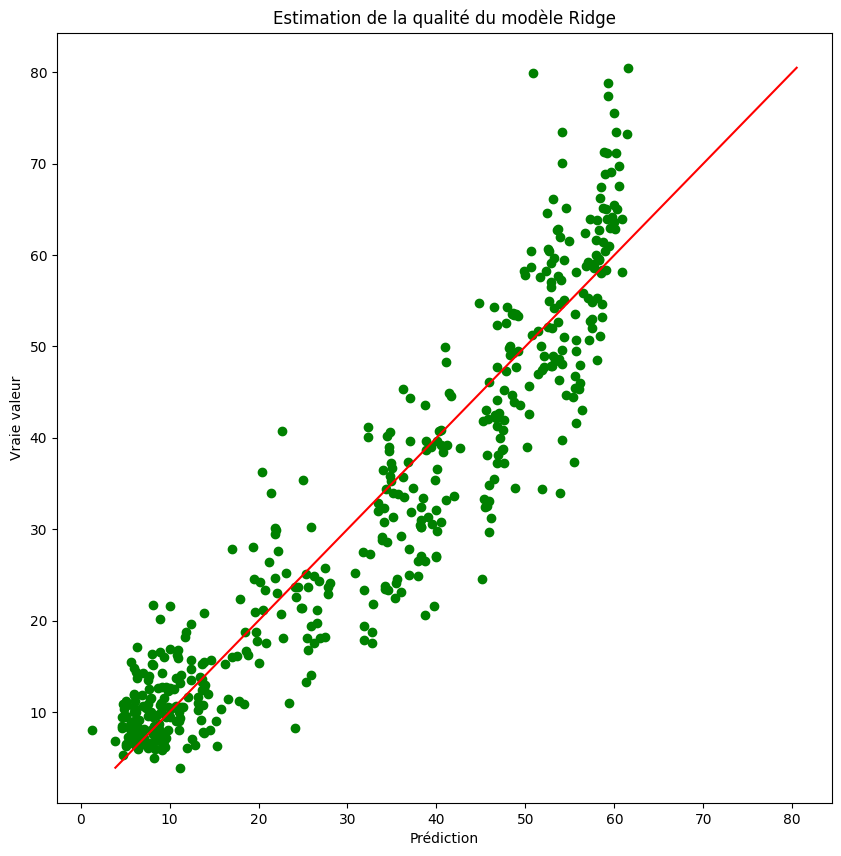

In [57]:
fig = plt.figure(figsize=(10,10))

plt.scatter(ridge_pred_test, y_test, c="green")

plt.plot((y_test.min(),y_test.max()),(y_test.min(),y_test.max()), color = "red")

plt.xlabel("Prédiction")
plt.ylabel("Vraie valeur")
plt.title("Estimation de la qualité du modèle Ridge")
plt.show();

Pour l'instant, c'est le modèle linéaire sans fonction de pénalité , avec 3 variables explicatives, qui est le meilleur modèle avec:
<br/> 
- Racine de la moyenne des ecart au carré : <br/>
2,63  

- Coefficient de détermination 1 - (  (y_true - y_pred)** 2).sum()  /  ((y_true - y_true.mean()) ** 2).sum()  
0,87